C:\Users\26257\AppData\Local\Temp\ipykernel_20772\693199316.py:12: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data//household_power_consumption.txt', sep=";")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


C:\Users\26257\AppData\Local\Temp\ipykernel_20772\693199316.py:20: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'])


Start Date:  2006-12-16 17:24:00
End Date:  2010-11-26 21:02:00
Epoch 1/10, Loss: 0.015625732019543648
Epoch 2/10, Loss: 0.009267276152968407
Epoch 3/10, Loss: 0.018207300454378128
Epoch 4/10, Loss: 0.015914229676127434
Epoch 5/10, Loss: 0.005373843014240265
Epoch 6/10, Loss: 0.02342190220952034
Epoch 7/10, Loss: 0.02800440788269043
Epoch 8/10, Loss: 0.010158008895814419
Epoch 9/10, Loss: 0.01474940124899149
Epoch 10/10, Loss: 0.01267610676586628


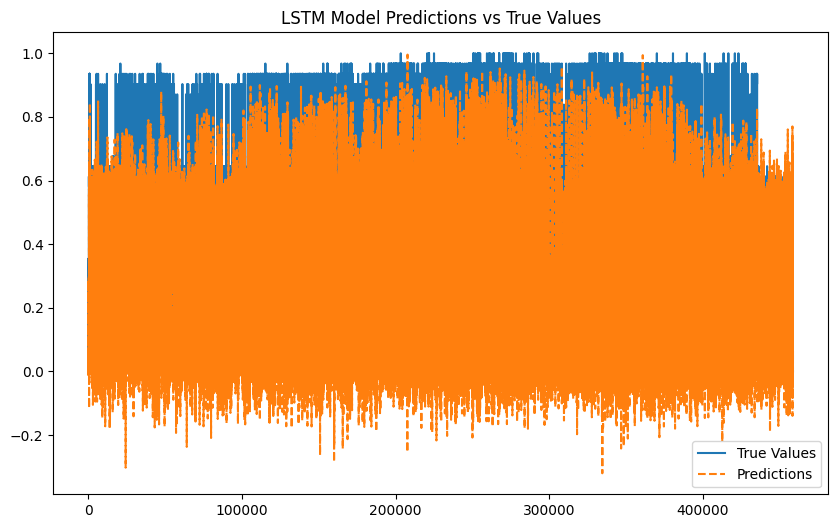

In [1]:
# %% 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# %% 
# Load data
df = pd.read_csv('data//household_power_consumption.txt', sep=";")
df.head()

# %% 
# Check the data
df.info()

# %% 
df['datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'])
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Handle missing values
df.dropna(inplace=True)

# %% 
print("Start Date: ", df['datetime'].min())
print("End Date: ", df['datetime'].max())

# %% 
# Split training and test sets
train, test = df.loc[df['datetime'] <= '2009-12-31'], df.loc[df['datetime'] > '2009-12-31']

# %% 
# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the feature columns (excluding 'datetime')
train_scaled = scaler.fit_transform(train.drop(columns=['datetime']))
test_scaled = scaler.transform(test.drop(columns=['datetime']))

# %% 
# Split X (features) and y (target)
# For example, if predicting "Global_active_power", use that as the target.
X_train = train_scaled[:, :-1]  # All columns except the target
y_train = train_scaled[:, -1]   # Assuming the last column is the target

X_test = test_scaled[:, :-1]
y_test = test_scaled[:, -1]

# %% 
# Create DataLoader for LSTM (we'll use a sequence length of 10 for simplicity)
sequence_length = 10

def create_sequences(features, target, seq_length):
    sequences = []
    labels = []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i+seq_length])
        labels.append(target[i+seq_length])
    return np.array(sequences), np.array(labels)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# %% 
# Build LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Using the output of the last time step
        return out

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size=X_train_seq.shape[2], hidden_size=64, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# %% 
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch.view(-1, 1))  # Reshape y_batch to match output
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# %% 
# Evaluate the model on the test set
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_pred.append(output.numpy())
        y_true.append(y_batch.numpy())

y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

# %% 
# Plot predictions against the ground truth
plt.figure(figsize=(10, 6))
plt.plot(y_true, label="True Values")
plt.plot(y_pred, label="Predictions", linestyle="--")
plt.legend()
plt.title("LSTM Model Predictions vs True Values")
plt.show()